In [3]:
import seaborn as sns

import sklearn
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score

import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm_notebook as tqdm
from __future__ import division
import pandas as pd
import seaborn as sb
import os
from scipy.spatial import distance
from scipy.cluster import hierarchy
from pandas import DataFrame
from glob import glob
import h5py

import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

import passivity_2p_imaging_utils as p2putils
import visualization_utils as vizutil
import matplotlib.cm as cm
from matplotlib.colors import Normalize
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

from scipy import signal

# import holoviews as hv
# hv.extension('matplotlib')
pyplot.switch_backend('agg')
# %output fig='svg' size=300

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
def safe_round_mean(x):
    m = np.round(np.mean(x))
    if np.isnan(m):
        return 0
    else:
        return int(m)

def safe_mean(x):
    m = np.mean(x)
    if np.isnan(m):
        return 0
    else:
        return np.mean(x)

In [5]:
#Params:
bTop = True
bOneFish = False # only run first fish for interactive development
# vmax = None # set to 95%
vmax = 100 
bSymmetric_vmax = False # We don't care about f-val < 1, but do when taking diff
plot_dir = "/data2/Plots/kanaka/"

reduce_func = lambda x: sum(x>100)/np.size(x)
# reduce_func = safe_round_mean
brain_map_reduce = safe_mean


# If the values are integers then
# the number of chords is directly scaled by the value, if the
# values are floats then the number of chords are apportioned such
# that the lowest value edge is given one chord and all other nodes
# are given nodes proportional to their weight.
chord_val_integer = True
chord_val_min = 1

# reduce_func = np.mean
# chord_val_integer = False
# chord_val_min = 1e-5



conds = ['shock','reexposed','control',]
fishids = [['f01606','f01604','f01547','f01550','f01553'],#,'f01597','f02326','f01520','f01527',],
           ['f01555','f01575','f01576','f01594','f01598'],
           ['f01736','f01732','f01733','f01735','f01729']]#,'f

In [6]:
regions = [u'in_l_vthal', u'in_r_vthal', u'in_l_raphe',
           u'in_r_raphe', u'in_l_dthal', u'in_r_dthal',
           u'in_l_LHb', u'in_r_LHb', u'in_l_tel', u'in_r_tel',
           u'in_l_MHb', u'in_r_MHb']
region_names = [r[3:] for r in regions]

In [7]:
def prepInputChordDiagram(Ms, target_bndx, region_bndxs,
                          target_name, region_names, func,
                          min_val=1e-5, integer=False):
    """
    Inputs:
    Ms is list of one or more (G or fval matrices)
    target_bndx is a boolean array speciifying the set of cells to which we want to understand the input.
    region_bndxs is a list of boolean arrays specifying a set of regions in the brain.
    target_name is the string of the target region
    region_names is a list of strings that must contain target_name
    func is a function mean, std.. that will be used to summarize the set of inputs between one region and another.
    min_val is a positive float that determines the minimum connection between regions
    integer will interpret each value as an int rather than float, and will usually increase # of lines
    """
    ret = None
    for iM, M in enumerate(Ms):
        # select columns corresponding with target region.
        target = M[:,target_bndx]
        for iR, region_bndx in enumerate(region_bndxs):
            # select rows associated with region
            block = target[region_bndx]
            # summarize the remaining block with the summary function 
            summary = func(block)
            if type(summary) is int:
                sum_shape = ()
            else:
                sum_shape=summary.shape
            if ret is None:
                ret = np.zeros([len(Ms), len(region_bndxs)] + list(sum_shape))
            ret[iM, iR] = summary
    # This yields a tensor of len(Ms, ie. #fish) x #input regions x dim(domain of func).
    # if func returns a scalar, this will be a matrix
    
    # make links df for chord
    links = DataFrame(0, index=np.arange(np.product(ret.shape)),
                  columns=["group", "source", "target", "value"])
    nodes = hv.Dataset(DataFrame(data=
                    {"index": np.arange(len(region_names)),
                    "name": region_names}),
                'index')
    target_idx = region_names.index(target_name)
    ncol = ret.shape[1]
    for iF, iS in np.ndindex(ret.shape):
        
        val = ret[iF,iS]
        if np.isnan(val) or val<=min_val:
            val = min_val
        else:
            if integer:
                val = int(val)
            else:
                val = float(val)
        links.iloc[iF*ncol+iS] = [iF, iS, target_idx, val]
    # return this tensor for doing statistiic and plot chord diagram
    return ret, links, nodes

def plotChordDiagram(links, nodes, group_n=None):
    options = {"Chord": 
               {"label_index": 'name',
                "color_index": 'name',
                "edge_color_index": 'source',
                "cmap": 'Category20',
                "edge_cmap": 'Category20'}
              }
    if group_n:
        dat = links.query('group=={}'.format(group_n))
    else:
        dat = links
    fig = hv.Chord(
            (dat, nodes),
            ['source', 'target'],
            ['value']).options(options)
    return fig


def prepDeltaInputChordDiagram(Ms_1, Ms_2, target_bndx, region_bndxs,
                          target_name, region_names, func,
                          min_val=1e-5):
    #subtracts Ms1 and Ms2, then call the above function I guess...
    diffM = [m1 - m2 for m1, m2 in zip(Ms_1, Ms_2)]
    return plotInputChordDiagram(diffM, target_bndx, region_bndxs,
                                 target_name, region_names, func,
                                min_val)

def plotInputBrainMap( M, df, target_bndx, Z, back_img, func, vmax=None, symmetric_vmax=False):
    """
    Inputs:
    M the G or fval matric
    df is the roi dataframe
    target_bndx is a boolean array specifying the set of cells to which we want to understand the input.
    Z: list of z-plane indices eg [0,2,4,6,8]
    back_img: list of background images of dim(Z+1), where 0 is max Z-project
    func is a function mean, std.. that will be used to summarize the set of inputs between one region and another.
    """
    # select columns corresponding with target region.
    target = M[:,target_bndx]
    # summarize across columns using the function 
    neurons_summary = np.apply_along_axis(func, 1, target)
    # This yields a vector of len #neurons.
    
    # Colormap
    cmap_ = cm.inferno
    if not vmax:
        vmax = np.percentile(fvals[0],95)
    if symmetric_vmax:
        vmin = -vmax
    else:
        vmin = 0
    norm_ = Normalize(vmin=vmin, vmax=vmax)
    m = cm.ScalarMappable(norm=norm_, cmap=cmap_)
    cmap = lambda x: m.to_rgba(x)[:3]
    
    
    # Plot each plane the rois colored based on the vector on top of the brain.
    fig, ax = plt.subplots(nZ+2, 1, figsize=[8,4*nZ],
                           gridspec_kw={"height_ratios":[0.05] + list(np.ones(nZ+1))})
    cb1 = mpl.colorbar.ColorbarBase(ax[0], cmap=cmap_,
                                norm=norm_,
                                orientation='horizontal')
    imgs = []
    for iz, z in enumerate(Z):
        idx = df.z==z
        #Select rois in raphe in this slices, and get their coordinates.
        coords = df[idx].coords
        weights = neurons_summary[idx]
        my_colors = np.array(map(cmap, weights))
        #Overlay the ROIs on the background image and display:
        img = vizutil.overlay_coords(back_img[iz], coords, my_colors, alpha=0.5)
        imgs.append(img)
        ax[iz+2].imshow(img,interpolation='nearest')
        ax[iz+2].set_title("z={}".format(z))
    img = np.array(imgs).max(0)
    ax[1].imshow(img,interpolation='nearest')
    ax[1].set_title("max z-project")
    
    plt.tight_layout()
    
    # Plot a z-project of all the rois
    return fig, neurons_summary

def plotDeltaInputBrainMap( M1, M2, df, target_bndx, Z, back_img, func):
    diffM = M1 - M2
    return plotInputBrainMap(diffM, df, target_bndx, Z, back_img, func)

In [8]:
# turn off interactive plotting
plt.ioff()

In [9]:
for ncond, cond in enumerate(conds):
    for nf, fid in enumerate(fishids[ncond]):
        f = p2putils.get_fish(all_data,fid)[0]
        print('Starting', f.fishid)
        
        #Load data
        Js = []
        for i in range(1,4):
            fn = glob(f.data_prefix[:-6]+'*ep{}*.mat'.format(i))[0]
            h5 = h5py.File(fn)
            J = np.array(h5["J"])
            Js.append(J)
        Js = np.array(Js)
        df = f.get_roi_table()
        
        Z = np.arange(0,f.num_zplanes)
        nZ = len(Z)
        back_img = []
        for z in Z:
            back_img.append(np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4))
        
        print("finished loading data. Making plots...")
        # MAKE PLOTS
        target_name = "r_raphe"
        target_bndx = np.array(df["in_"+target_name])
        region_bndxs = [np.array(df[r]) for r in regions]
        
        # PLOT
        _, links, nodes = prepInputChordDiagram(Js, target_bndx, region_bndxs,
                              target_name, region_names, reduce_func,
                              min_val=chord_val_min, integer=chord_val_integer)
        for t in range(3):
            chord_fig = plotChordDiagram(links, nodes, group_n=t)
            brain_map_fig, _ = plotInputBrainMap(fvals[t], df, target_bndx, Z, back_img, brain_map_reduce, vmax=vmax, symmetric_vmax=bSymmetric_vmax)
            
            # SAVE PLOT
            plot_fn = "{}_target={}_window={}".format(
                f.fishid, target_name, t)
            hv.output(chord_fig, filename=plot_dir+plot_fn+"_fval.svg")
            brain_map_fig.savefig(plot_dir+plot_fn+"_brain_map.svg")

        print('Done', f.fishid)#, fn)
        if bOneFish:
            break
    if bOneFish:
        break

Starting f01606


/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/skimage/measure/_marching_cubes_lewiner.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _marching_cubes_lewiner_cy
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/skimage/measure/_marching_cubes_classic.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _marching_cubes_classic_cy
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/skimage/measure/_label.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ccomp import label_cython as clabel
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/skimage/measure/pnpoly.py:1: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._pnpoly import _grid_points_in_poly, _poin

finished loading data. Making plots...


IndexError: boolean index did not match indexed array along dimension 1; dimension is 15712 but corresponding boolean dimension is 14538

In [10]:
plt.ion()

In [11]:
import torch
def corrcoef(x):
    # calculate covariance matrix of rows
    mean_x = torch.mean(x, 1, keepdim=True)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # normalize covariance matrix
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c)+1e-8)
    c = c.div(stddev.expand_as(c).t()+1e-8)

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

In [14]:
j = torch.from_numpy(Js[0])

In [17]:
j.cuda()

RuntimeError: CUDA error: out of memory

In [19]:
row_corr = np.corrcoef(Js[0])

In [ ]:
row_linkage = hierarchy.linkage(
    distance.pdist(row_corr), method='ward')

In [ ]:
col_corr = np.corrcoef(Js[0].T)
col_linkage = hierarchy.linkage(
    distance.pdist(col_corr.T), method='ward')

In [ ]:
from scipy.cluster import hierarchy

In [ ]:
g_nclust = 10
row_clusters = hierarchy.fcluster(row_linkage,g_nclust,criterion='maxclust')
col_clusters = hierarchy.fcluster(col_linkage,g_nclust,criterion='maxclust')

In [ ]:
vmax = max(np.abs(np.percentile(G,0.01)), np.abs(np.percentile(G,0.99)))

In [ ]:
cm = sb.clustermap(G.cpu().numpy(), row_linkage=row_linkage, row_colors=[cm_cycle(c) for c in row_clusters],
        col_linkage=col_linkage, col_colors=[cm_cycle(c) for c in col_clusters],
        figsize=(20, 20),cmap="RdBu_r", vmin=-vmax,vmax=vmax)

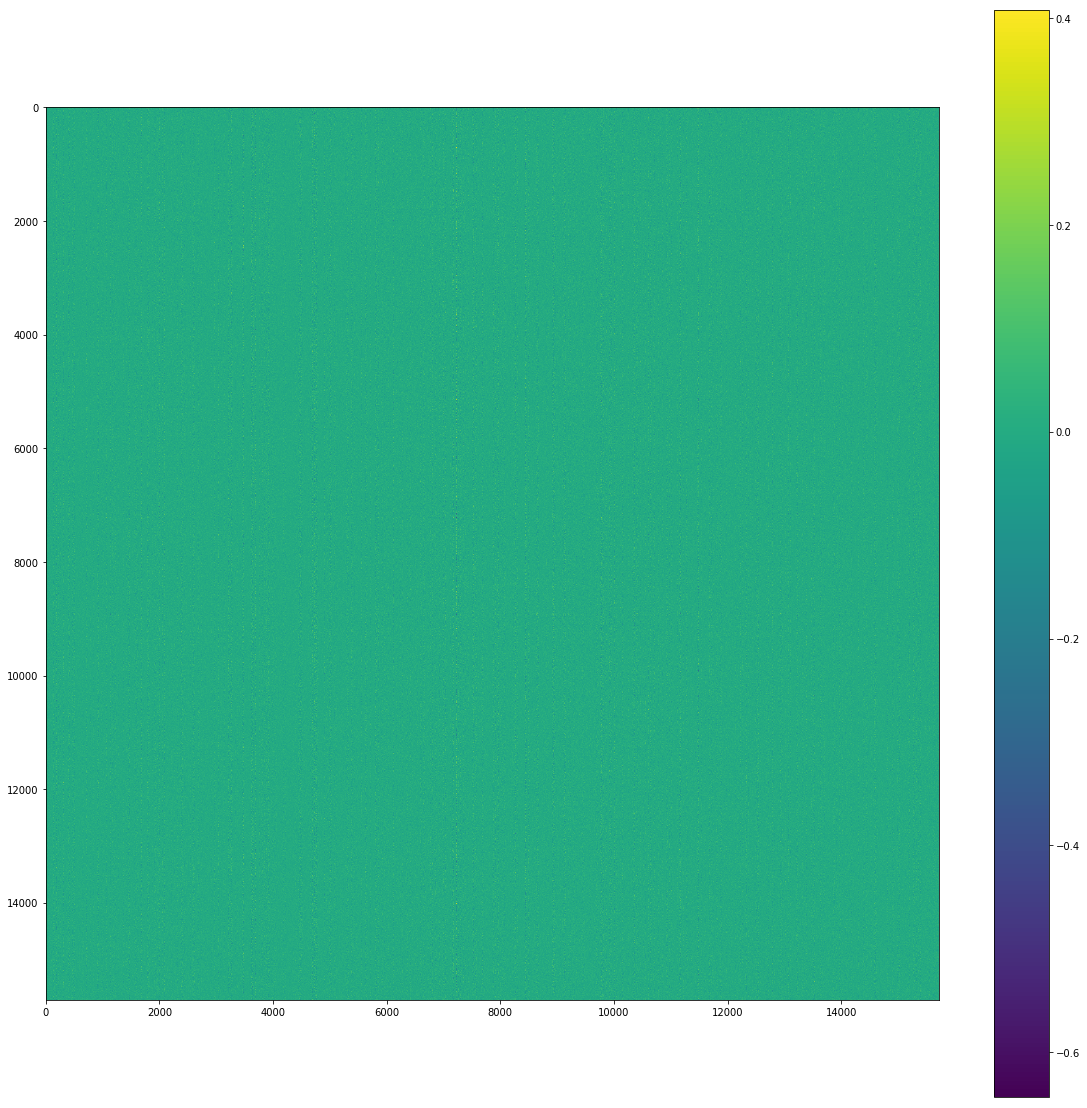

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(Js[0])
plt.colorbar()

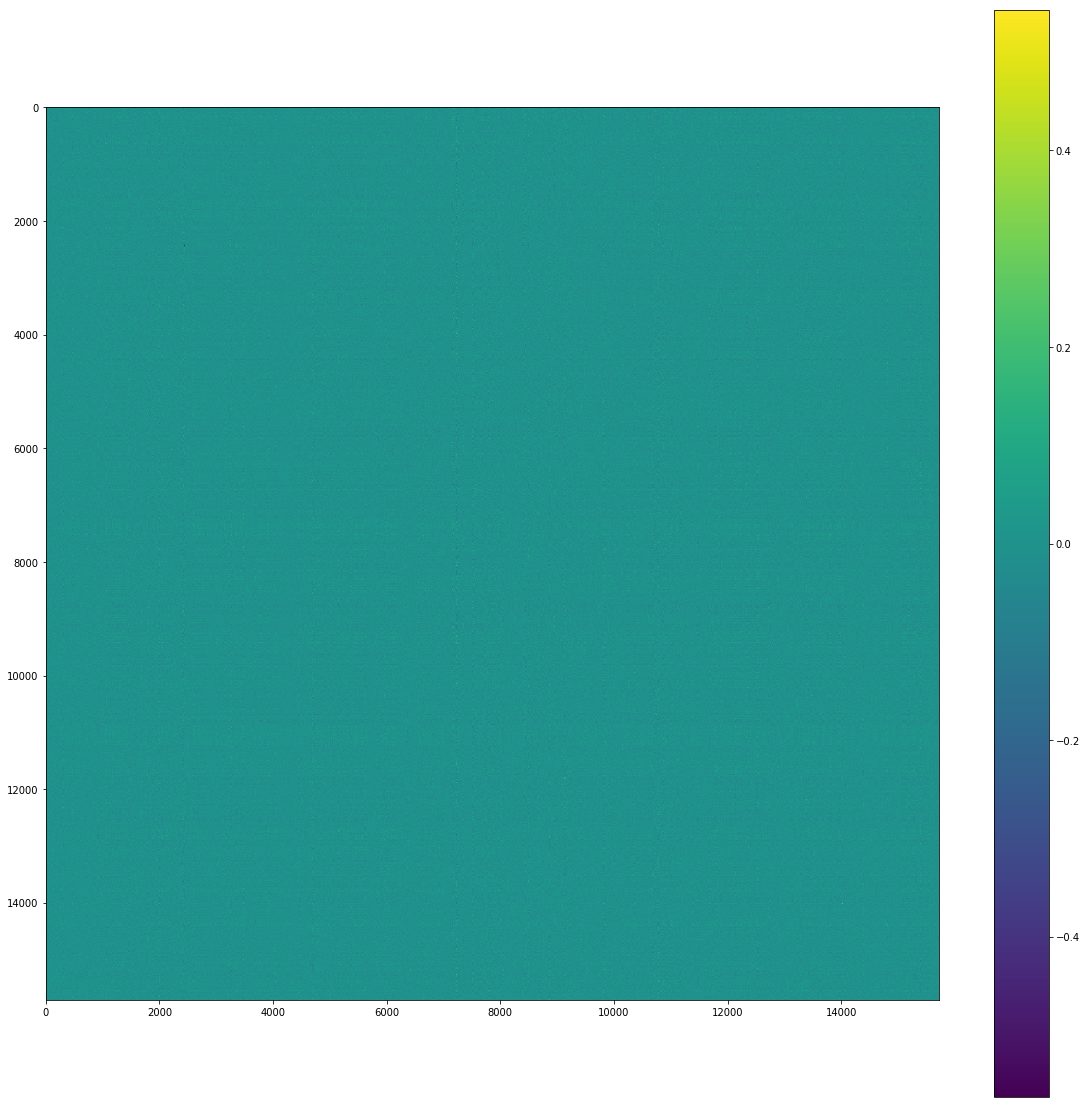

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(Js[1])
plt.colorbar()

# Dev

In [18]:
# turn on interactive plotting
plt.ion()

In [20]:
Z = np.arange(0,f.num_zplanes)
nZ = len(Z)
back_img = []
for z in Z:
    back_img.append(np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4))

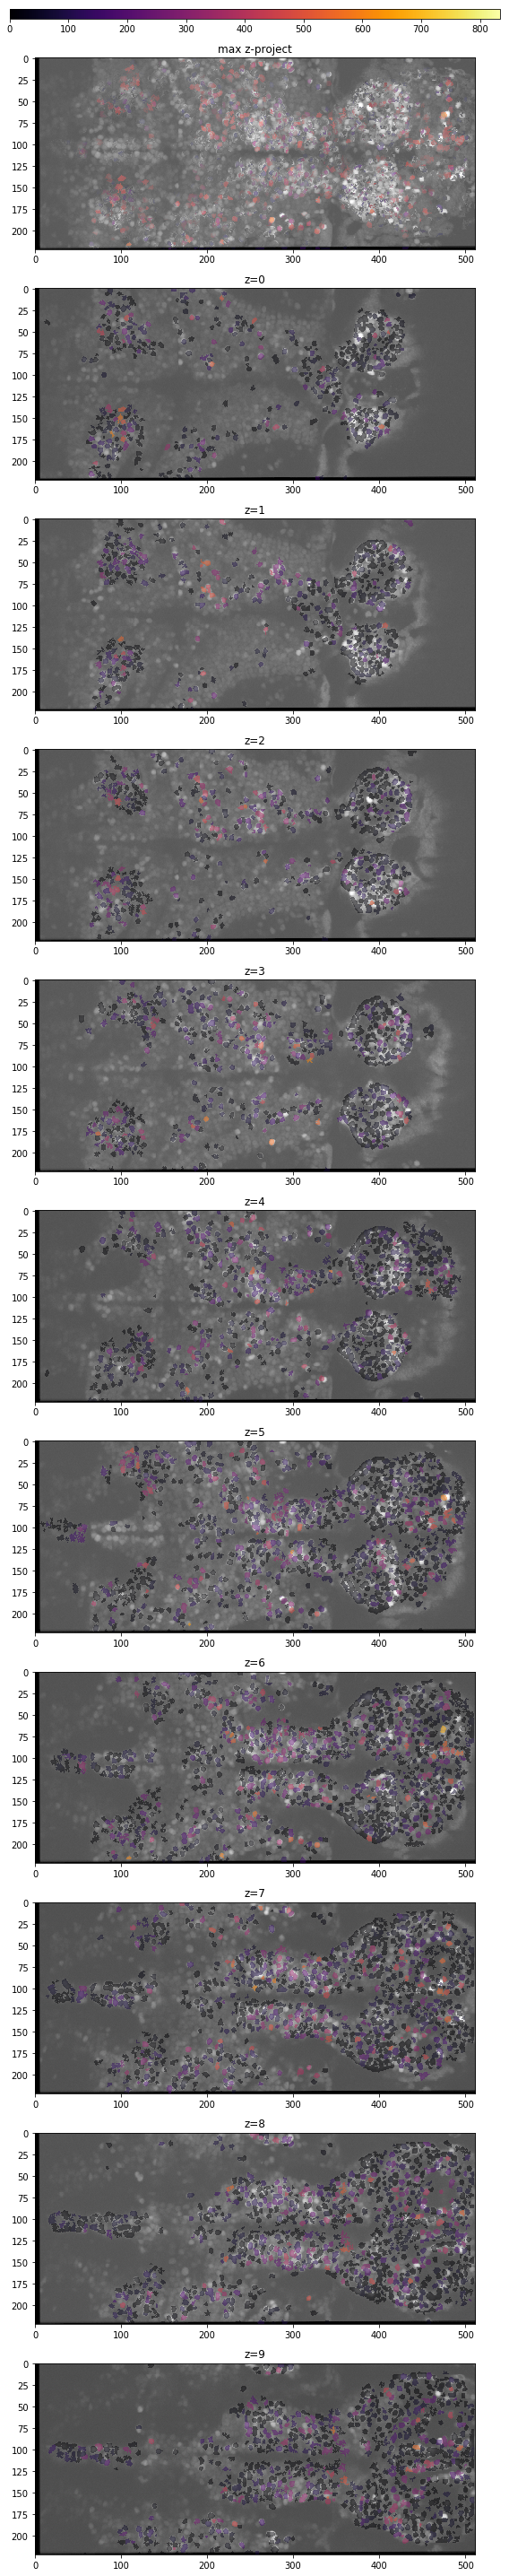

In [80]:
plotDeltaInputBrainMap(fvals[0], fvals[2], df, target_bndx, Z, back_img, np.mean);

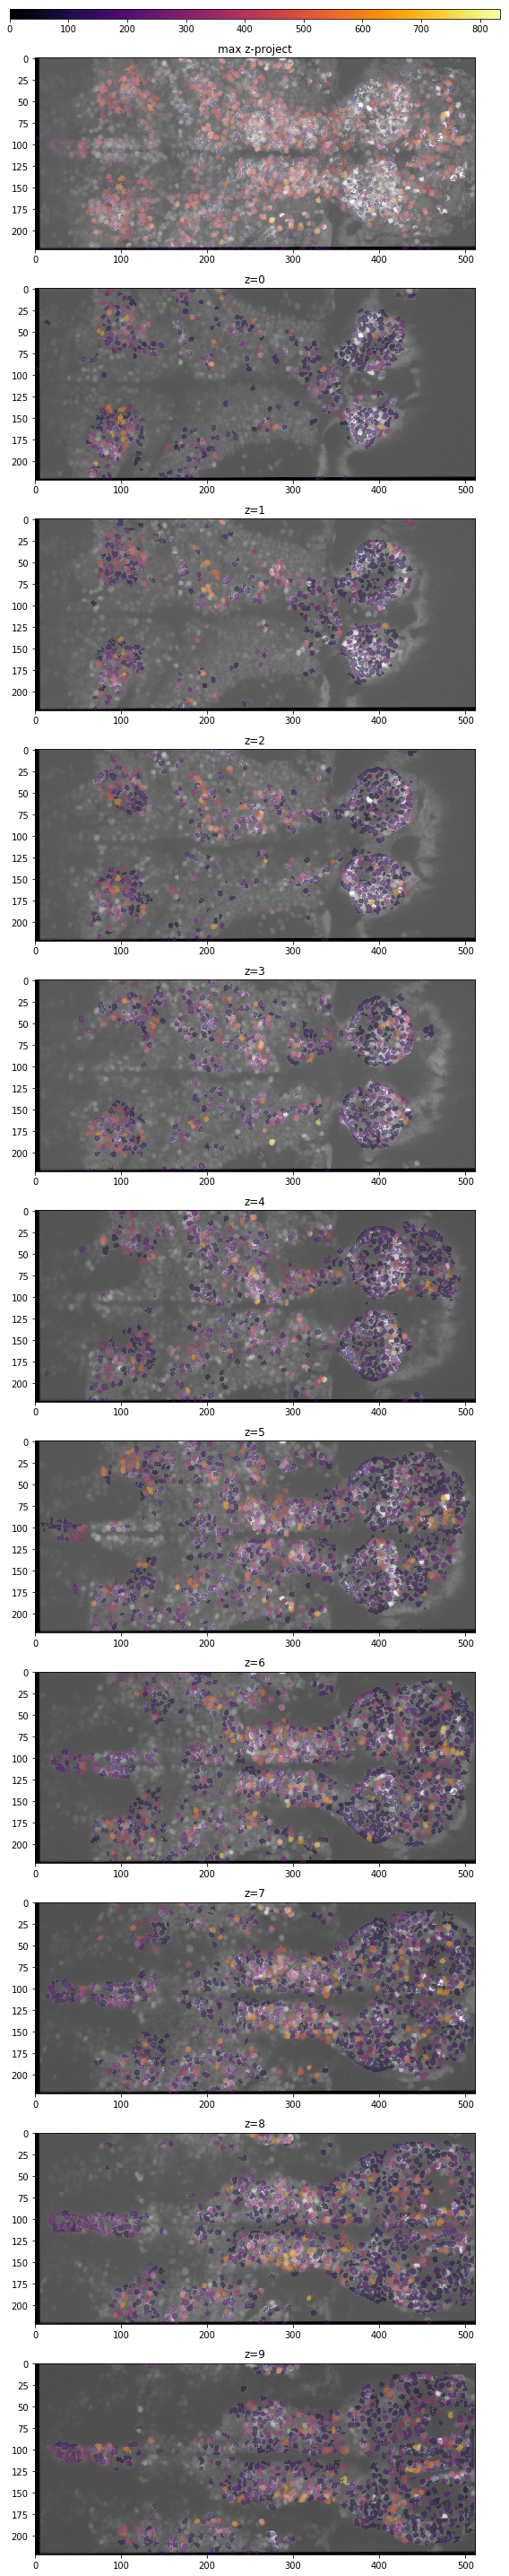

In [73]:
plotInputBrainMap(fvals[0], df, target_bndx, Z, back_img, np.mean);

In [95]:
target_name = "r_raphe"
target_bndx = np.array(df["in_"+target_name])
region_bndxs = [np.array(df[r]) for r in regions]
o = plotInputChordDiagram(fvals, target_bndx, region_bndxs,
                                          target_name, region_names,
                          lambda x: sum(x>1.5), 1, integer=True)
dat, links, nodes = o

In [96]:
options = {"Chord": {"label_index": 'name', "color_index": 'name', "edge_color_index": 'source', 
          "cmap": 'Category20', "edge_cmap": 'Category20'}}
fig = hv.Chord((links.query('group==0'), nodes), ['source', 'target'], ['value']).options(options)
fig

:Chord   [source,target]   (value)

In [86]:
hv.output(fig, filename="test.svg")

:Chord   [source,target]   (value)

In [78]:
fig

:Chord   [source,target]   (value)

In [281]:
dat, links, nodes = plotDeltaInputChordDiagram([fvals+100, fvals],
                                               [fvals, fvals*2],
                           target_bndx, region_bndxs, 
                           target_name, region_names, np.mean)